Task: to perform 

In [164]:
# Importing the file:

import pandas as pd

df = pd.read_csv('petrol_consumption.csv')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Petrol_tax                    48 non-null     float64
 1   Average_income                48 non-null     int64  
 2   Paved_Highways                48 non-null     int64  
 3   Population_Driver_licence(%)  48 non-null     float64
 4   Petrol_Consumption            48 non-null     int64  
dtypes: float64(2), int64(3)
memory usage: 2.0 KB


In [3]:
df.head()

,Petrol_tax,Average_income,Paved_Highways,Population_Driver_licence(%),Petrol_Consumption
0,9.0,3571,1976,0.525,541
1,9.0,4092,1250,0.572,524
2,9.0,3865,1586,0.580,561
3,7.5,4870,2351,0.529,414
4,8.0,4399,431,0.544,410


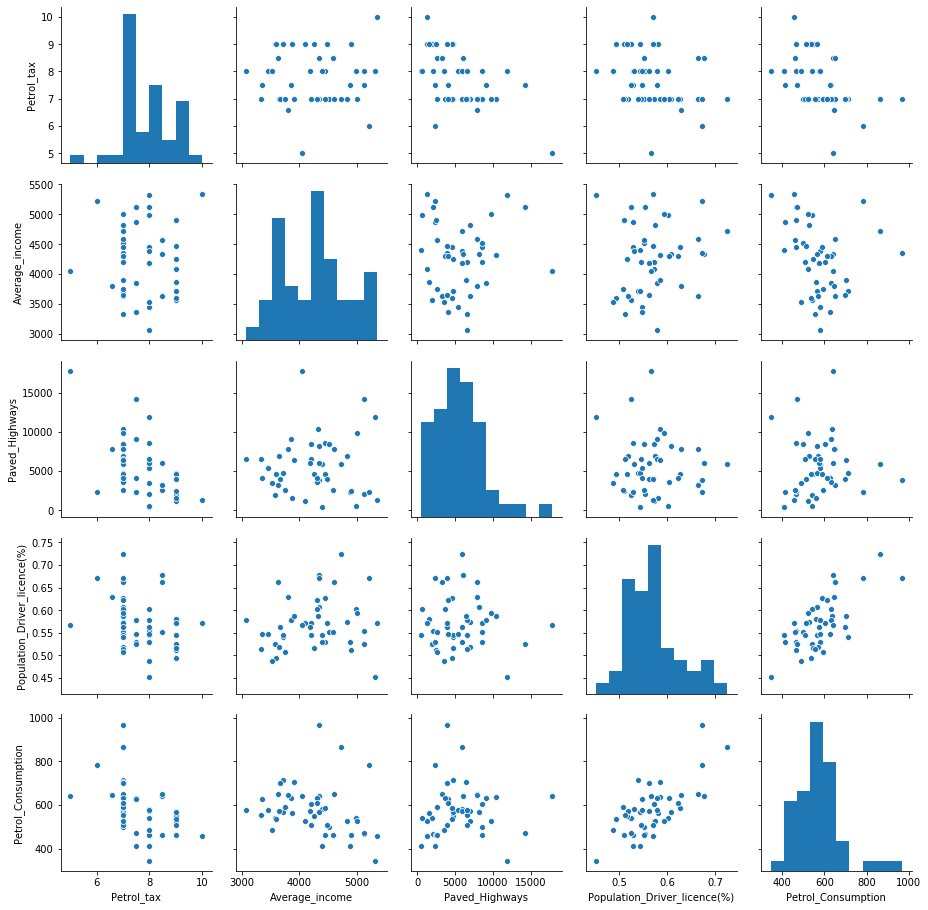

In [4]:
# Building graphs:

import seaborn as sns

sns.pairplot(df)

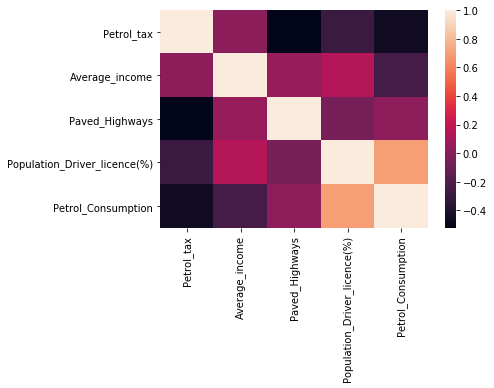

In [5]:
sns.heatmap(df.corr())

The following graphs show that the strongest dependency is between Petrol Consumption and Population_driver_licence(%)

Text(0.5, 1.0, 'Petrol_tax')

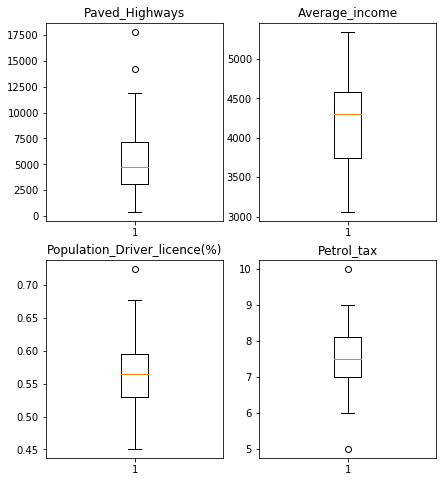

In [7]:
# Plotting box plots for other values: 
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2)
fig.set(figheight=8)
fig.set(figwidth=7)

ax[0][0].boxplot(df['Paved_Highways'])
ax[0][0].set_title('Paved_Highways')

ax[0][1].boxplot(df['Average_income'])
ax[0][1].set_title('Average_income')

ax[1][0].boxplot(df['Population_Driver_licence(%)'])
ax[1][0].set_title('Population_Driver_licence(%)')

ax[1][1].boxplot(df['Petrol_tax'])
ax[1][1].set_title('Petrol_tax')

Let's build model for values as they are for further comparison

In [224]:
# 1. Build model for all variables as-is.

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline


y = df['Petrol_Consumption']
X = df.drop('Petrol_Consumption', axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=142, shuffle=True)


lr = LinearRegression()
lasso = Lasso(alpha=0.01)
ridge = Ridge(alpha=0.001)

lr.fit(X_train, Y_train)
lasso.fit(X_train, Y_train)
ridge.fit(X_train, Y_train)


pred_lr = lr.predict(X_test)
pred_lasso = lasso.predict(X_test)
pred_ridge = ridge.predict(X_test)

print('Scores: ')
print('Linear Regression', lr.score(X_test, Y_test))
print('Lasso Regression', lasso.score(X_test, Y_test))
print('Ridge Regression', ridge.score(X_test, Y_test))

# Average of 3 methods 
vr = VotingRegressor([('linear', lr), ('Lasso', lasso), ('Ridge', ridge)])
vr.fit(X_train, Y_train)
vr.predict(X_test)


print('Average score: ', vr.score(X_test, Y_test))


Scores: 
Linear Regression 0.6556871688743853
Lasso Regression 0.655005164780716
Ridge Regression 0.6535648505224738
Average score:  0.6547564008998487


Let's try the following steps to increase model accuracy:   
1) drop columns that have least influence on target value;   
2) drop rows with outliers;   
3) perform categorization and re-scaling   

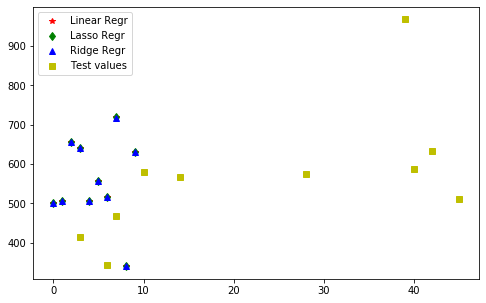

In [225]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8,5))
plt.plot(pred_lr, 'r*', label='Linear Regr')
plt.plot(pred_lasso, 'gd', label='Lasso Regr')
plt.plot(pred_ridge, 'b^', label='Ridge Regr')
plt.plot(Y_test, 'ys', label='Test values')
plt.legend()

Now let's try to drop some columns that have least influence on target variable:

In [226]:
df_small = df.drop(['Petrol_tax','Paved_Highways'], axis = 1)

In [227]:
y = df_small['Petrol_Consumption']
X = df_small.drop('Petrol_Consumption', axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=142, shuffle=True)


lr_small = LinearRegression()
lasso_small = Lasso(alpha=0.01)
ridge_small = Ridge(alpha=0.001)

lr_small.fit(X_train, Y_train)
lasso_small.fit(X_train, Y_train)
ridge_small.fit(X_train, Y_train)


pred_lr_small = lr_small.predict(X_test)
pred_lasso_small = lasso_small.predict(X_test)
pred_ridge_small = ridge_small.predict(X_test)

print('Scores: ')
print('Linear Regression', lr_small.score(X_test, Y_test))
print('Lasso Regression', lasso_small.score(X_test, Y_test))
print('Ridge Regression', ridge_small.score(X_test, Y_test))

# Average of 3 methods 
vr = VotingRegressor([('linear', lr_small), ('Lasso', lasso_small), ('Ridge', ridge_small)])
vr.fit(X_train, Y_train)
vr.predict(X_test)


print('Average score: ', vr.score(X_test, Y_test))

Scores: 
Linear Regression 0.6572334731234248
Lasso Regression 0.6565198049530802
Ridge Regression 0.6546766637252899
Average score:  0.6561492440701329


We see that column drop improved model insignificantly.

Let's drop rows with outliers.

To identify outliers 2 methods can be used: Z-score or IQR   
We will use IQR

In [228]:
# Cropping outliers in 3 columns (Petrol_tax, Paved_Highways, Population_driver_licence) basing on box plots using IQR:

def remove_IQR_outliers(df, column_name):
    '''
    Removes IQR-detected outliers found in given column in given dataframe 
    
    Parameters:
    df - pandas.DataFrame
    column_name - name of column in df
    
    Returns: pandas.DataFrame without rows where outliers were found
    '''
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3-Q1
    clean_df = df[~((df[column_name] < (Q1-1.5*IQR)) | (df[column_name] > (Q3 + 1.5*IQR)))]
    return clean_df


# Remove Petrol_tax outliers:
df_cleaned_tax = remove_IQR_outliers(df, 'Petrol_tax')

# Remove Paved_Highways outliers:
df_cleaned_hwys = remove_IQR_outliers(df_cleaned_tax, 'Paved_Highways')

# Remove 'Population_Driver_licence(%)' outliers:
df_no_outliers = remove_IQR_outliers(df_cleaned_hwys, 'Population_Driver_licence(%)')

print('Shape after removing outliers:', df_no_outliers.shape)

Shape after removing outliers: (44, 5)


Let's rebuild models and compare the results:

In [229]:
y = df_no_outliers['Petrol_Consumption']
X = df_no_outliers.drop('Petrol_Consumption', axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=142, shuffle=True)


lr_o = LinearRegression()
lasso_o = Lasso(alpha=0.01)
ridge_o = Ridge(alpha=0.001)

lr_o.fit(X_train, Y_train)
lasso_o.fit(X_train, Y_train)
ridge_o.fit(X_train, Y_train)


pred_lr_o = lr_o.predict(X_test)
pred_lasso_o = lasso_o.predict(X_test)
pred_ridge_o = ridge_o.predict(X_test)

print('Scores: ')
print('Linear Regression', lr_o.score(X_test, Y_test))
print('Lasso Regression', lasso_o.score(X_test, Y_test))
print('Ridge Regression', ridge_o.score(X_test, Y_test))

# Average of 3 methods 
vr = VotingRegressor([('linear', lr_o), ('Lasso', lasso_o), ('Ridge', ridge_o)])
vr.fit(X_train, Y_train)
vr.predict(X_test)


print('Average score: ', vr.score(X_test, Y_test))

Scores: 
Linear Regression 0.48326057285279866
Lasso Regression 0.48279165199950347
Ridge Regression 0.4811960030844816
Average score:  0.48242381093777076


So we see that removing rows with outliers reduced accuracy of our model. That's why we return to the initial dataset.

The next try is to group values and/or perform scaling; re-build model.   
We will include column 'Paved_Highways' to perform categorization and see if it helps our model.

In [230]:
df_scaled = df.copy()
df_scaled.drop('Petrol_tax', axis = 1, inplace = True)
#Let's divide values of column 'Paved_Highways' into 4 groups: <3000, 3000-7500, 7500-11000 , >13000
df_scaled['Paved_Highways']=pd.cut(df_scaled['Paved_Highways'], bins=[0, 3000, 7500, 11000, 13000, 20000],
                                  labels=[0, 1, 2, 3, 4])
df_scaled = pd.get_dummies(df_scaled, columns=['Paved_Highways'])

# Let's measure average income in thousands $:
df_scaled['Average_income'] = df_scaled['Average_income']/1000
df_scaled.rename(columns={'Average_income':'Average_income(thousands)'}, inplace=True)

df_scaled.head()

,Average_income(thousands),Population_Driver_licence(%),Petrol_Consumption,Paved_Highways_0,Paved_Highways_1,Paved_Highways_2,Paved_Highways_3,Paved_Highways_4
0,3.571,0.525,541,1,0,0,0,0
1,4.092,0.572,524,1,0,0,0,0
2,3.865,0.580,561,1,0,0,0,0
3,4.870,0.529,414,1,0,0,0,0
4,4.399,0.544,410,1,0,0,0,0


In [231]:
y = df_scaled['Petrol_Consumption']
X = df_scaled.drop('Petrol_Consumption', axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=142, shuffle=True)


lr_scaled = LinearRegression()
lasso_scaled = Lasso(alpha=0.01)
ridge_scaled = Ridge(alpha=0.001)

lr_scaled.fit(X_train, Y_train)
lasso_scaled.fit(X_train, Y_train)
ridge_scaled.fit(X_train, Y_train)


pred_lr_scaled = lr_scaled.predict(X_test)
pred_lasso_scaled = lasso_scaled.predict(X_test)
pred_ridge_scaled = ridge_scaled.predict(X_test)

print('Scores: ')
print('Linear Regression', lr_scaled.score(X_test, Y_test))
print('Lasso Regression', lasso_scaled.score(X_test, Y_test))
print('Ridge Regression', ridge_scaled.score(X_test, Y_test))

# Average of 3 methods 
vr = VotingRegressor([('linear', lr_scaled), ('Lasso', lasso_scaled), ('Ridge', ridge_scaled)])
vr.fit(X_train, Y_train)
vr.predict(X_test)


print('Average score: ', vr.score(X_test, Y_test))

Scores: 
Linear Regression 0.6903076835144877
Lasso Regression 0.689334324874374
Ridge Regression 0.6877369295908606
Average score:  0.6891329196552807


We see that dropping column and scaling improved accuracy of our model; although dropping 'Paved_Highways' column at first slightly increased accuracy, its categorization helped to improve the model better than dropping.